# Исследование гипотез для увеличения выручки интернет-магазина
<br>


**Описание проекта**<br>

Вместе с отделом маркетинга крупного интернет-магазина мы подготовили список гипотез для увеличения выручки. <br>
Приоритизируем гипотезы, запустим A/B-тест и проанализируем результаты.

Проект разделим на 2 части:

**Часть 1. Приоритизация гипотез**<br> 
В файле hypothesis.csv 9 гипотез по увеличению выручки интернет-магазина с указанными параметрами Reach, Impact, Confidence, Effort. <br>
Описание данных:
 - Hypothesis — краткое описание гипотезы,
 - Reach — охват пользователей по 10-балльной шкале,
 - Impact — влияние на пользователей по 10-балльной шкале,
 - Confidence — уверенность в гипотезе по 10-балльной шкале,
 - Efforts — затраты ресурсов на проверку гипотезы по 10-балльной шкале. Чем больше значение Efforts, тем дороже проверка гипотезы.

Цель исследования: определить гипотезу, которая приведет к наибольшему увеличению выручки.

**Часть 2. Анализ A/B-теста**<br> 
У нас есть результаты A/B-теста, которые собраны в файлах orders.csv и visitors.csv.<br>
Задача - проанализировать эти результаты.<br>

Описание данных:<br>

*Файл orders.csv.*
 - transactionId — идентификатор заказа,
 - visitorId — идентификатор пользователя, совершившего заказ,
 - date — дата, когда был совершён заказ,
 - revenue — выручка заказа,
 - group — группа A/B-теста, в которую попал заказ.

*Файл visitors.csv.*
 - date — дата,
 - group — группа A/B-теста,
 - visitors — количество пользователей в указанную дату в указанной группе A/B-теста.

По итогам анализа нам будет нужно сделать выбор:
   1. Остановить тест, зафиксировать победу одной из групп,
   2. Остановить тест, зафиксировать отсутствие различий между группами,
   3. Продолжить тест.

**Итак, общий план исследования:**

1. Обзор данных,
2. Предобработка данных,
3. Приоритизация гипотез,
4. Анализ результатов A/B-теста, принятие решения по по дальнейшим действиям.


### часть: Приоритизация гипотез

In [1]:
# Импортируем нужные библиотеки для чтения файлов, построения графиков и проведения расчетов

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import math
import seaborn as sns
from scipy import stats
from datetime import timedelta
import datetime as dt

In [2]:
# Загрузим файл
hypothesis = pd.read_csv('/datasets/hypothesis.csv', sep=',')
pd.options.display.max_colwidth = 150  

# Сразу ограничим показ данных формата float до 3х символов после точки
pd.options.display.float_format = '{:,.3f}'.format

hypothesis.head(9)

,Hypothesis,Reach,Impact,Confidence,Efforts
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5


In [3]:
# Изучим общую информацию о файле
hypothesis.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Hypothesis  9 non-null      object
 1   Reach       9 non-null      int64 
 2   Impact      9 non-null      int64 
 3   Confidence  9 non-null      int64 
 4   Efforts     9 non-null      int64 
dtypes: int64(4), object(1)
memory usage: 488.0+ bytes


In [4]:
# Переведем названия столбцов в нижний регистр
hypothesis.columns = hypothesis.columns.str.lower()

# Оптимизируем память
hypothesis['reach'] = hypothesis['reach'].astype('int32')
hypothesis['impact'] = hypothesis['impact'].astype('int32')
hypothesis['confidence'] = hypothesis['confidence'].astype('int32')
hypothesis['efforts'] = hypothesis['efforts'].astype('int32')

In [5]:
# Проверим изменения
hypothesis.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   hypothesis  9 non-null      object
 1   reach       9 non-null      int32 
 2   impact      9 non-null      int32 
 3   confidence  9 non-null      int32 
 4   efforts     9 non-null      int32 
dtypes: int32(4), object(1)
memory usage: 344.0+ bytes


**Посчитаем ICE для гипотез и отсортируем их по убыванию приоритета**

In [6]:
hypothesis['ICE'] = (hypothesis['impact'] * hypothesis['confidence']) / hypothesis['efforts']
hypothesis[['hypothesis', 'ICE']].sort_values(by='ICE', ascending=False).round(2)

,hypothesis,ICE
8,"Запустить акцию, дающую скидку на товар в день рождения",16.200
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",13.330
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",11.200
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",8.000
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",7.000
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2.000
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",1.330
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",1.120
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",1.000


Видим, что топ 3 гипотезы по ICE - это:<br>

 - "Запустить акцию, дающую скидку на товар в день рождения",<br>
 - "Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",<br>
 - "Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок".

**Посчитаем RICE для гипотез и отсортируем их по убыванию приоритета**

In [7]:
hypothesis['RICE'] = (hypothesis['reach'] * hypothesis['impact'] * hypothesis['confidence']) / hypothesis['efforts']
hypothesis[['hypothesis', 'RICE']].sort_values(by='RICE', ascending=False).round(2)

,hypothesis,RICE
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",112.000
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",56.000
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",40.000
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",40.000
8,"Запустить акцию, дающую скидку на товар в день рождения",16.200
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",9.000
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",4.000
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",4.000
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3.000


Топ 3 гипотезы по RICE:<br>

 - "Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок".
 - "Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",<br>
 - "Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей".<br>

**Посмотим, как изменилась приоритизация гипотез при применении RICE вместо ICE**

In [8]:
hypothesis.sort_values(by='RICE', ascending=False)

,hypothesis,reach,impact,confidence,efforts,ICE,RICE
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5,11.200,112.000
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3,7.000,56.000
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6,13.333,40.000
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3,8.000,40.000
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5,16.200,16.200
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8,1.125,9.000
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10,2.000,4.000
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3,1.333,4.000
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1,1.000,3.000


Результаты по расчетам ICE и RICE сильно отличаются.<br>
Секрет кроется в параметре Reach: RICE учитывает охват, а ICE - нет.<br>

При расчёте RICE на первом месте гипотеза №7: её параметр reach равен 10, у остальных гипотез он меньше.<br>
Получается, важна не только сила гипотезы, но и сколько пользователей она затронет.

**Общий вывод по Части 1:**

Мы изучили файл с 9 гипотезами по увеличению выручки интернет-магазина с указанными параметрами Reach, Impact, Confidence, Effort.<br>
Также скорректировали названия столбцов.

Применили фреймворк ICE для приоритизации гипотез.<br>
*Топ 3 гипотезы по ICE:*<br>
 - "Запустить акцию, дающую скидку на товар в день рождения",<br>
 - "Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",<br>
 - "Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок".

Применили фреймворк RICE для приоритизации гипотез.<br>
*Топ 3 гипотезы по RICE:*<br>

 - "Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок".
 - "Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",<br>
 - "Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей".<br>
 
В итоге выяснили, что результаты по расчетам ICE и RICE сильно отличаются.<br>
Секрет кроется в параметре Reach: RICE учитывает охват, а ICE - нет.<br>

При расчёте RICE на первом месте гипотеза №7: её параметр reach равен 10, у остальных гипотез он меньше.<br>
Итак, важна не только сила гипотезы, но и сколько пользователей она затронет.

### часть: Анализ A/B-теста

Мы провели A/B-тест и получили результаты, которые описаны в файлах:<br>
 - /datasets/orders.csv,
 - /datasets/visitors.csv.

Описание данных из /datasets/orders.csv

 - transactionId — идентификатор заказа;
 - visitorId — идентификатор пользователя, совершившего заказ;
 - date — дата, когда был совершён заказ;
 - revenue — выручка заказа;
 - group — группа A/B-теста, в которую попал заказ.

Описание данных из /datasets/visitors.csv

 - date — дата;
 - group — группа A/B-теста;
 - visitors — количество пользователей в указанную дату в указанной группе A/B-теста

**Предобработка данных**

In [9]:
# Загрузим данные
orders = pd.read_csv('/datasets/orders.csv', sep=',')
visitors = pd.read_csv('/datasets/visitors.csv', sep=',')

In [10]:
# Изучаем файлы по порядку, сначала заказы
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   transactionId  1197 non-null   int64 
 1   visitorId      1197 non-null   int64 
 2   date           1197 non-null   object
 3   revenue        1197 non-null   int64 
 4   group          1197 non-null   object
dtypes: int64(3), object(2)
memory usage: 46.9+ KB


In [11]:
orders.head()

,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B


Видим 5 столбцов.<br>
Дату приведем к типу datetime, а также оптимизируем память.

In [12]:
orders['date'] = orders['date'].map(
    lambda x: dt.datetime.strptime(x, '%Y-%m-%d')
)

orders['transactionId'] = orders['transactionId'].astype('int32')
orders['visitorId'] = orders['visitorId'].astype('int32')
orders['revenue'] = orders['revenue'].astype('int32')

In [13]:
# Проверим изменения
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   transactionId  1197 non-null   int32         
 1   visitorId      1197 non-null   int32         
 2   date           1197 non-null   datetime64[ns]
 3   revenue        1197 non-null   int32         
 4   group          1197 non-null   object        
dtypes: datetime64[ns](1), int32(3), object(1)
memory usage: 32.9+ KB


In [14]:
# Далее посмотрим количество уникальных пользователей
orders['visitorId'].nunique()

1031

In [15]:
# Проверим отсутствие дубликатов
orders.duplicated().sum()

0

In [16]:
# Теперь изучим файл с пользователями
visitors.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   date      62 non-null     object
 1   group     62 non-null     object
 2   visitors  62 non-null     int64 
dtypes: int64(1), object(2)
memory usage: 1.6+ KB


In [17]:
visitors.head()

,date,group,visitors
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
4,2019-08-05,A,756


Снова скорректируем тип данных - приведем столбец date к типу datetime, а также оптимизируем память.

In [18]:
visitors['date'] = visitors['date'].map(
    lambda x: dt.datetime.strptime(x, '%Y-%m-%d')
)

visitors['visitors'] = visitors['visitors'].astype('int32')

In [19]:
# Проверим изменения
visitors.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   date      62 non-null     datetime64[ns]
 1   group     62 non-null     object        
 2   visitors  62 non-null     int32         
dtypes: datetime64[ns](1), int32(1), object(1)
memory usage: 1.3+ KB


In [20]:
# Проверим отсутствие дубликатов
visitors.duplicated().sum()

0

In [21]:
# Проверим распределение по группам
visitors['group'].value_counts()

B    31
A    31
Name: group, dtype: int64

In [22]:
# Проверим, есть ли значения, которые встречаются в обеих группах
# Заодно посмотрим количество пользователей в каждой группе
                                                                                                     
duplicated_users = len(np.intersect1d(orders.query('group == "A"')['visitorId'].unique(), orders.query('group == "B"')['visitorId'].unique()))
print('Сколько пользователей попало в обе группы:', duplicated_users)
print('Количество пользователей в группе А:', orders.query('group == "A"')['visitorId'].nunique())
print('Количество пользователей в группе В:', orders.query('group == "B"')['visitorId'].nunique())

Сколько пользователей попало в обе группы: 58
Количество пользователей в группе А: 503
Количество пользователей в группе В: 586


В обе группы попало 58 пользователей, то есть около 10% от каждой группы.<br>
Лучше исключить их из анализа, чтобы не искажать результаты теста.

In [23]:
# Определим id тех пользователей, кто попал в обе группы
list_id = np.intersect1d(orders.query('group == "A"')['visitorId'].unique(), 
                         orders.query('group == "B"')['visitorId'].unique())

# Переведем массив в список
list_id = list_id.tolist()

# Исключим повторные id
orders = orders[~orders.visitorId.isin(list_id)]

In [24]:
# Проверим, есть ли теперь значения, которые встречаются в обеих группах
                                                                                                     
len(np.intersect1d(orders.query('group == "A"')['visitorId'].unique(), orders.query('group == "B"')['visitorId'].unique()))

0

**Вывод по предобработке таблиц orders и visitors**

Мы скорректировали неверные типы данных в столбцах со временем. <br>
Дубликаты не обнаружили, кроме того исключили значения, повторяющиеся в обеих группах.<br>

Можем приступать к анализу А/В-теста.

Для начала соберем все коммулятивные данные.<br>
Объединим таблицы и добавим в новую таблицу: 
 - дату, 
 - группу A/B-теста, 
 - число уникальных заказов в группе теста по указанную дату включительно,
 - число уникальных пользователей, совершивших хотя бы 1 заказ в группе теста по указанную дату включительно, 
 - суммарную выручку заказов в группе теста по указанную дату включительно.

In [25]:
datesGroups = orders[['date', 'group']].drop_duplicates()

ordersAggregated = datesGroups.apply(
    lambda x: orders[
        np.logical_and(
            orders['date'] <= x['date'], orders['group'] == x['group']
        )
    ].agg(
        {
            'date': 'max',
            'group': 'max',
            'transactionId': 'nunique',
            'visitorId': 'nunique',
            'revenue': 'sum',
        }
    ),
    axis=1,
).sort_values(by=['date', 'group'])

visitorsAggregated = datesGroups.apply(
    lambda x: visitors[
        np.logical_and(
            visitors['date'] <= x['date'], visitors['group'] == x['group']
        )
    ].agg({'date': 'max', 'group': 'max', 'visitors': 'sum'}),
    axis=1,
).sort_values(by=['date', 'group'])

cumulativeData = ordersAggregated.merge(
    visitorsAggregated, left_on=['date', 'group'], right_on=['date', 'group']
)
cumulativeData.columns = [
    'date',
    'group',
    'orders',
    'buyers',
    'revenue',
    'visitors',
]

In [26]:
# Просмотрим случайно выбранные строки
cumulativeData.sample(10)

,date,group,orders,buyers,revenue,visitors
11,2019-08-06,B,112,109,690490,3935
10,2019-08-06,A,114,104,515332,3985
18,2019-08-10,A,170,158,1013731,6262
2,2019-08-02,A,42,36,234381,1338
49,2019-08-25,B,440,424,4294526,15127
54,2019-08-28,A,434,413,3036933,16970
17,2019-08-09,B,176,173,1162961,5908
48,2019-08-25,A,380,362,2597907,14943
16,2019-08-09,A,155,143,861456,5856
6,2019-08-04,A,77,71,388030,2562


Проверим, корректно ли был содан датафрейм cummulativeData.<br>
Совпадают ли минимальная и максимальная даты в этом датафрейме с минимальной и максимальной датой в исходных данных: 

In [47]:
# Отсортируем датафрейм cummulativeData по дате:
cumulativeData.sort_values(by='date')

,date,group,orders,buyers,revenue,visitors,conversion
0,2019-08-01,A,23,19,142779,719,0.032
1,2019-08-01,B,17,17,59758,713,0.024
2,2019-08-02,A,42,36,234381,1338,0.031
3,2019-08-02,B,40,39,221801,1294,0.031
4,2019-08-03,A,66,60,346854,1845,0.036
...,...,...,...,...,...,...,...
57,2019-08-29,B,510,490,4746610,17708,0.029
58,2019-08-30,A,460,437,3311413,18037,0.026
59,2019-08-30,B,531,511,4955833,18198,0.029
60,2019-08-31,A,468,445,3364656,18736,0.025


In [54]:
# Теперь посмотрим минимальные и максимальные даты исходных файлов orders и visitors:

print('Минимальная дата файла orders:', orders['date'].min())
print('Максимальная дата файла orders:', orders['date'].max())
print()
print('Минимальная дата файла visitors:', visitors['date'].min())
print('Максимальная дата файла visitors:', visitors['date'].max())

Минимальная дата файла orders: 2019-08-01 00:00:00
Максимальная дата файла orders: 2019-08-31 00:00:00

Минимальная дата файла visitors: 2019-08-01 00:00:00
Максимальная дата файла visitors: 2019-08-31 00:00:00


Как видим, даты совпадают: первая дата 01 августа 2019, финальная - 31 августа 2019.

#### График кумулятивной выручки по группам.

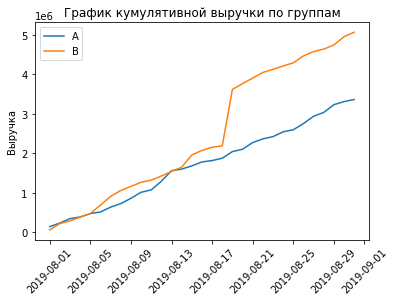

In [28]:
# датафрейм с кумулятивным количеством заказов и кумулятивной выручкой по дням в группе А
cumulativeRevenueA = cumulativeData[cumulativeData['group']=='A'][['date','revenue', 'orders']]

# датафрейм с кумулятивным количеством заказов и кумулятивной выручкой по дням в группе B
cumulativeRevenueB = cumulativeData[cumulativeData['group']=='B'][['date','revenue', 'orders']]

# Строим график выручки группы А
plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue'], label='A')

# Строим график выручки группы B
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue'], label='B')

plt.title('График кумулятивной выручки по группам')
plt.ylabel("Выручка")
plt.xticks(rotation=45)
plt.legend() 
plt.show()

Видим резкий скачок у группы В: возможно из-за аномально большого количества заказов или выброса по среднему чеку.

#### График кумулятивного среднего чека по группам.

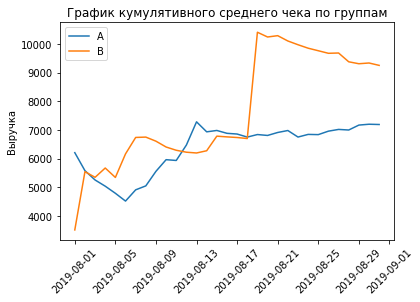

In [29]:
# Для среднего кумулятивного чека по группам разделим кумулятивную выручку на кумулятивное число заказов
plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue']/cumulativeRevenueA['orders'], label='A')
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue']/cumulativeRevenueB['orders'], label='B')
plt.title('График кумулятивного среднего чека по группам')
plt.ylabel("Выручка")
plt.xticks(rotation=45)
plt.legend()
plt.show()

Кумулятивное значение среднего чека по сегментам нестабильно.<br>
Выделяется резкий скачок у группы В после 17 августа.<br>
Понадобится анализ выбросов, которые сильно влияют на данные.

#### График относительного изменения кумулятивного среднего чека группы B к группе A.

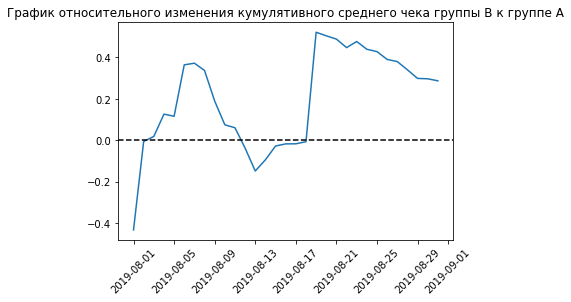

In [30]:
# Соберем данные в одном датафрейме
mergedCumulativeRevenue = cumulativeRevenueA.merge(
    cumulativeRevenueB, left_on='date', right_on='date', how='left', suffixes=['A', 'B']
)

# Построим график отношения средних чеков
plt.plot(mergedCumulativeRevenue['date'],
         (mergedCumulativeRevenue['revenueB']/mergedCumulativeRevenue['ordersB'])/
         (mergedCumulativeRevenue['revenueA']/mergedCumulativeRevenue['ordersA'])-1)

# Добавим ось X
plt.axhline(y=0, color='black', linestyle='--') 
plt.title('График относительного изменения кумулятивного среднего чека группы B к группе A')
plt.xticks(rotation=45)
plt.show()

Значения сильно меняются в определенные даты.<br>
Видимо, именно тогда были аномальные заказы.

#### График кумулятивной конверсии по группам.

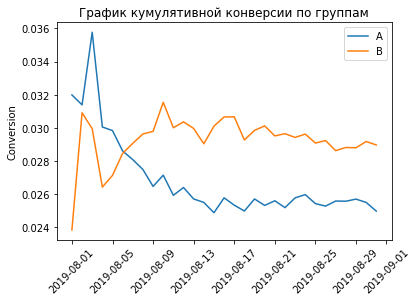

In [31]:
# Посчитаем кумулятивную конверсию
cumulativeData['conversion'] = cumulativeData['orders']/cumulativeData['visitors']

# Выделим данные по группе A
cumulativeDataA = cumulativeData[cumulativeData['group']=='A']

# Выделим данные по группе B
cumulativeDataB = cumulativeData[cumulativeData['group']=='B']

# Построим графики
plt.plot(cumulativeDataA['date'], cumulativeDataA['conversion'], label='A')
plt.plot(cumulativeDataB['date'], cumulativeDataB['conversion'], label='B')
plt.title('График кумулятивной конверсии по группам')
plt.ylabel('Conversion')
plt.xticks(rotation=45)
plt.legend()
plt.show()

В начале теста группы стартовали с разных значений.<br>
Конверсия группы А была больше, но быстро снизилась и уступила лидерство группе В.

#### График относительного изменения кумулятивной конверсии группы B к группе A.

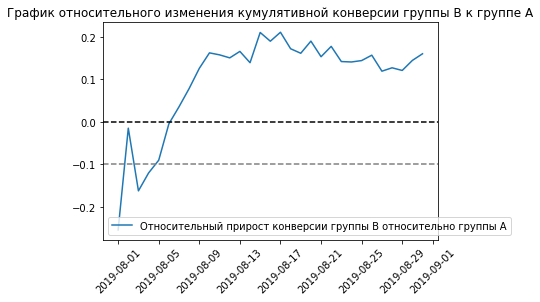

In [32]:
# Соединим данные по группам А и В и построим график
mergedCumulativeConversions = cumulativeDataA[['date','conversion']].merge(
    cumulativeDataB[['date','conversion']], left_on='date', right_on='date', how='left', suffixes=['A', 'B']
)
plt.plot(
    mergedCumulativeConversions['date'], mergedCumulativeConversions['conversionB']/
    mergedCumulativeConversions['conversionA']-1, label="Относительный прирост конверсии группы B относительно группы A")

plt.legend()

# Добавим ось X черным цветом на уровне у=0
plt.axhline(y=0, color='black', linestyle='--')

# Добавим еще одну ось X серым цветом на уровне у=-0.1
plt.axhline(y=-0.1, color='grey', linestyle='--')
plt.title('График относительного изменения кумулятивной конверсии группы B к группе A')
plt.xticks(rotation=45)
plt.show()

Группа В лидирует по конверсии практически с самого начала теста: стабильные +15 и до 20% относительно группы А.

#### Точечный график количества заказов по пользователям.

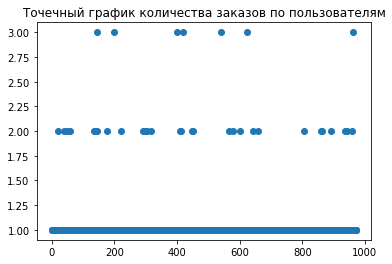

In [33]:
# Создадим таблицу с заказами:
orders_per_user = orders.groupby('visitorId', as_index=False).agg({'transactionId':pd.Series.nunique})\
                         .rename(columns={'transactionId':'orders'})

# Построим точечный график:
x_values = pd.Series(range(0,len(orders_per_user['orders'])))
plt.title('Точечный график количества заказов по пользователям')
plt.scatter(x_values, orders_per_user['orders'])
plt.show()

Больше всего пользователей, которые совершили 1 заказ. <br>
Пользователей с двумя заказами значительно меньше. <br>
Совершивших 3 заказа всего семеро, возможно, здесь скрываются выбросы.

#### 95-й и 99-й перцентили количества заказов на пользователя,  выбор границы для определения аномальных пользователей.

In [34]:
print(np.percentile(orders_per_user['orders'], [95, 99])) 

[1. 2.]


 - 95% пользователей совершают не больше 1 заказа, <br>
 - 99% совершают 2 заказа.<br>

Значит, ситуации с 3 заказами будем считать аномалией.

#### Точечный график стоимостей заказов.

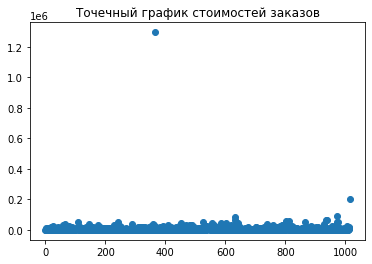

In [35]:
x_values = pd.Series(range(0,len(orders['revenue'])))

plt.scatter(x_values, orders['revenue'])
plt.title('Точечный график стоимостей заказов');
plt.show()

Очевидно выделяются 2 выброса, один из них - заказ стоимостью почти 1,3 миллиона. Видимо, именно здесь причина резкого скачка на первых графиках кумулятивной выручки и среднего чека.<br>

Уберем выбросы из графика и увеличим масштаб для остальных данных.

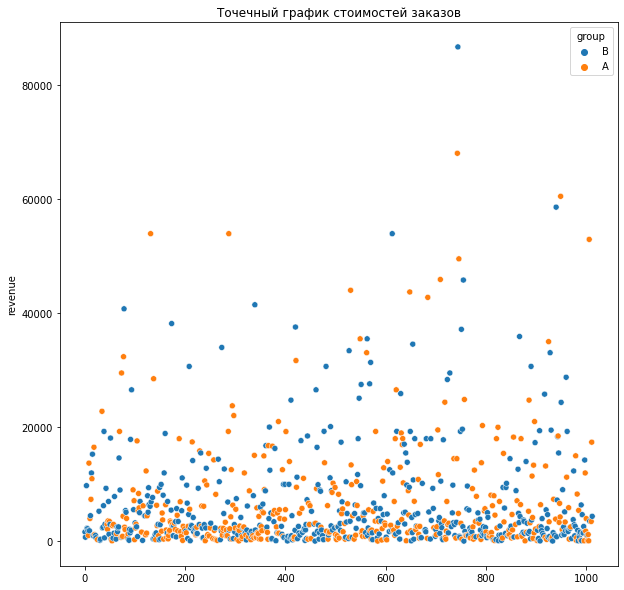

In [36]:
orders_ok = orders.query('revenue<200000')

x_values = pd.Series(range(0,orders_ok['revenue'].count()))
plt.figure(figsize=(10, 10))
sns.scatterplot(x=x_values, y="revenue", hue="group",
                     data=orders_ok)
plt.title('Точечный график стоимостей заказов');

Основная часть всех заказов - стоимостью до 20 000.

#### 95-й и 99-й перцентили стоимости заказов, выбор границы для определения аномальных заказов.

In [37]:
np.percentile(orders['revenue'], [95, 99])

array([26785., 53904.])

 - до 95% заказов с чеком 26 785, и<br>
 - до 99% заказов с чеком 53 904.<br>

Границей для определения аномальных заказов определим значение 53 904.

#### Статистическая значимость различий в конверсии между группами по «сырым» данным.

Подготовим данные:<br>
Соберем в общую таблицу все данные по заказам и визитам, добавим кумулятивные показатели.

In [38]:
visitorsADaily = visitors[visitors['group'] == 'A'][['date', 'visitors']]
visitorsADaily.columns = ['date', 'visitorsPerDateA']

visitorsACummulative = visitorsADaily.apply(
    lambda x: visitorsADaily[visitorsADaily['date'] <= x['date']].agg(
        {'date': 'max', 'visitorsPerDateA': 'sum'}
    ),
    axis=1,
)
visitorsACummulative.columns = ['date', 'visitorsCummulativeA']

visitorsBDaily = visitors[visitors['group'] == 'B'][['date', 'visitors']]
visitorsBDaily.columns = ['date', 'visitorsPerDateB']

visitorsBCummulative = visitorsBDaily.apply(
    lambda x: visitorsBDaily[visitorsBDaily['date'] <= x['date']].agg(
        {'date': 'max', 'visitorsPerDateB': 'sum'}
    ),
    axis=1,
)
visitorsBCummulative.columns = ['date', 'visitorsCummulativeB']

ordersADaily = (
    orders[orders['group'] == 'A'][['date', 'transactionId', 'visitorId', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'transactionId': pd.Series.nunique, 'revenue': 'sum'})
)
ordersADaily.columns = ['date', 'ordersPerDateA', 'revenuePerDateA']

ordersACummulative = ordersADaily.apply(
    lambda x: ordersADaily[ordersADaily['date'] <= x['date']].agg(
        {'date': 'max', 'ordersPerDateA': 'sum', 'revenuePerDateA': 'sum'}
    ),
    axis=1,
).sort_values(by=['date'])
ordersACummulative.columns = [
    'date',
    'ordersCummulativeA',
    'revenueCummulativeA',
]

ordersBDaily = (
    orders[orders['group'] == 'B'][['date', 'transactionId', 'visitorId', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'transactionId': pd.Series.nunique, 'revenue': 'sum'})
)
ordersBDaily.columns = ['date', 'ordersPerDateB', 'revenuePerDateB']

ordersBCummulative = ordersBDaily.apply(
    lambda x: ordersBDaily[ordersBDaily['date'] <= x['date']].agg(
        {'date': 'max', 'ordersPerDateB': 'sum', 'revenuePerDateB': 'sum'}
    ),
    axis=1,
).sort_values(by=['date'])
ordersBCummulative.columns = [
    'date',
    'ordersCummulativeB',
    'revenueCummulativeB',
]

cummulative = (
    ordersADaily.merge(
        ordersBDaily, left_on='date', right_on='date', how='left'
    )
    .merge(ordersACummulative, left_on='date', right_on='date', how='left')
    .merge(ordersBCummulative, left_on='date', right_on='date', how='left')
    .merge(visitorsADaily, left_on='date', right_on='date', how='left')
    .merge(visitorsBDaily, left_on='date', right_on='date', how='left')
    .merge(visitorsACummulative, left_on='date', right_on='date', how='left')
    .merge(visitorsBCummulative, left_on='date', right_on='date', how='left')
)

Теперь мы можем посчитать статистическую значимость различия в конверсии между группами.<br>
Создадим переменные ordersByUsersA и ordersByUsersB со столбцами ['userId', 'orders'].<br>
Укажем число совершённых заказов для пользователей, которые заказывали хотя бы 1 раз. 

In [39]:
ordersByUsersA = (
    orders[orders['group'] == 'A']
    .groupby('visitorId', as_index=False)
    .agg({'transactionId': pd.Series.nunique})
)
ordersByUsersA.columns = ['userId', 'orders']

ordersByUsersB = (
    orders[orders['group'] == 'B']
    .groupby('visitorId', as_index=False)
    .agg({'transactionId': pd.Series.nunique})
)
ordersByUsersB.columns = ['userId', 'orders']

Объявим переменные sampleA и sampleB, в которых пользователям из разных групп будет соответствовать количество заказов.<br>
Чтобы подготовить выборки к проверке критерием Манна-Уитни, присвоим нулевые значения тем пользователям, которые ничего не заказали. 

In [40]:
sampleA = pd.concat(
    [
        ordersByUsersA['orders'],
        pd.Series(
            0,
            index=np.arange(
                cummulative['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

sampleB = pd.concat(
    [
        ordersByUsersB['orders'],
        pd.Series(
            0,
            index=np.arange(
                cummulative['visitorsPerDateB'].sum() - len(ordersByUsersB['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

Воспользуемся критерием Манна-Уитни для разности двух долей.<br>
Сформулируем гипотезы.

 - H0: Конверсия в группе A равна конверсии в группе B (статистически значимых различий в конверсиях между группами нет),

 - H1: Конверсия в группе A не равна конверсии в группе B (есть статистически значимые различия).<br>
 
Уровнем статистической значимости alpha примем значение 0,05.

In [41]:
print("p-value = {0:.3f}".format(stats.mannwhitneyu(sampleA, sampleB, alternative = 'two-sided')[1]))
print("Относительный прирост конверсии группы B = {0:.3f}".format(sampleB.mean()/sampleA.mean()-1)) 

p-value = 0.011
Относительный прирост конверсии группы B = 0.160


Подтвердилась гипотеза H1: конверсия в группе A не равна конверсии в группе B, есть статистически значимые различия в конверсиях между группами.<br>

Относительный прирост конверсии группы В к А равен 16%

#### Cтатистическая значимость различий в среднем чеке заказа между группами по «сырым» данным.

Снова воспользуемся критерием Манна-Уитни. <br>
Сформулируем гипотезы.

 - H0: Средний чек заказов для групп A и В совпадает (статистически значимых различий в среднем чеке между группами нет),

 - H1: Средний чек заказов для групп A и В различаются (есть статистически значимые различия).<br>

Уровнем статистической значимости alpha примем значение 0,05.

In [42]:
print("p-value = {0:.3f}".format(stats.mannwhitneyu(orders[orders['group']=='A']['revenue'], orders[orders['group']=='B']['revenue'], alternative = 'two-sided')[1]))
print("Относительный показатель 'B' и 'A' = {0:.3f}".format(orders[orders['group']=='B']['revenue'].mean()/orders[orders['group']=='A']['revenue'].mean()-1)) 

p-value = 0.829
Относительный показатель 'B' и 'A' = 0.287


Подтвердилась гипотеза H0: по "сырым" данным средние чеки похожи. <br>
Можно считать, что значимых различий в среднем чеке между группами нет.<br>
Хотя средний чек группы B заметно больше среднего чека группы A (почти на 29%), наблюдаемые различия не являются значимыми при таком уровне значимости, а следовательно были получены случайно.

#### Статистическая значимость различий в конверсии между группами по «очищенным» данным.

Подготовим очищенные от аномалий данные.
В предыдущих расчётах мы определили аномальных пользователей, которые совершили:
 - 3 заказа,
 - заказ дороже 53 904 рублей.<br>

Сделаем срезы пользователей:
 - с числом заказов больше 2 — usersWithManyOrders
 - совершивших заказы дороже 53 904 — usersWithExpensiveOrders.<br>
 
Объединим их в таблицу abnormalUsers. <br>Посмотрим количество аномальных пользователей методом shape()

In [62]:
usersWithManyOrders = pd.concat(
    [
        ordersByUsersA[ordersByUsersA['orders'] > 2]['userId'],
        ordersByUsersB[ordersByUsersB['orders'] > 2]['userId'],
    ],
    axis=0,
)

usersWithExpensiveOrders = orders[orders['revenue'] > 53904]['visitorId']
abnormalUsers = (
    pd.concat([usersWithManyOrders, usersWithExpensiveOrders], axis=0)
    .drop_duplicates()
    .sort_values()
)
print("Всего аномальных пользователей" ,len(abnormalUsers)) 

Всего аномальных пользователей 16


In [44]:
# Отфильтруем аномальных пользователей:

sampleAFiltered = pd.concat(
    [
        ordersByUsersA[
            np.logical_not(ordersByUsersA['userId'].isin(abnormalUsers))
        ]['orders'],
        pd.Series(
            0,
            index=np.arange(
                cummulative['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

sampleBFiltered = pd.concat(
    [
        ordersByUsersB[
            np.logical_not(ordersByUsersB['userId'].isin(abnormalUsers))
        ]['orders'],
        pd.Series(
            0,
            index=np.arange(
                cummulative['visitorsPerDateB'].sum() - len(ordersByUsersB['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

Никак не обойтись без критерия Манна-Уитни для разности двух долей.<br>
Сформулируем гипотезы.

 - H0: Конверсия в группе A равна конверсии в группе B (статистически значимых различий в конверсиях между группами нет),

 - H1: Конверсия в группе A не равна конверсии в группе B (есть статистически значимые различия).<br>
 
Уровнем статистической значимости alpha примем значение 0,05.

In [45]:
print("p-value = {0:.3f}".format(stats.mannwhitneyu(sampleAFiltered, sampleBFiltered, alternative = 'two-sided')[1]))
print("Относительный показатель 'B' и 'A' = {0:.3f}".format(sampleBFiltered.mean()/sampleAFiltered.mean()-1)) 

p-value = 0.007
Относительный показатель 'B' и 'A' = 0.189


В очищенных данных конверсия группы В снова превышает конверсию группы А со статистической значимостью.

Значит, нулевую гипотезу Н0 о том, что конверсия в группе A равна конверсии в группе B, отвергаем.<br>

Преимущество группы B над A составляет почти 19%.

#### Статистическая значимость различий в среднем чеке заказа между группами по «очищенным» данным.

Критерий Манна-Уитни, формулировка гипотез:

 - H0: Средний чек заказов для групп A и В совпадает (статистически значимых различий в средних чеках между группами нет),

 - H1: Средний чек заказов для групп A и В различается (есть статистически значимые различия).<br>

Уровнем статистической значимости alpha примем значение 0,05.

In [46]:
print(
    "p-value = {0:.3f}".format(
        stats.mannwhitneyu(
            orders[
                np.logical_and(
                    orders['group'] == 'A',
                    np.logical_not(orders['visitorId'].isin(abnormalUsers)),
                )
            ]['revenue'],
            orders[
                np.logical_and(
                    orders['group'] == 'B',
                    np.logical_not(orders['visitorId'].isin(abnormalUsers)),
                )
            ]['revenue'],
        )[1]
    )
)

print(
    "Относительный показатель В и А = {0:.3f}".format(
        orders[
            np.logical_and(
                orders['group'] == 'B',
                np.logical_not(orders['visitorId'].isin(abnormalUsers)),
            )
        ]['revenue'].mean()
        / orders[
            np.logical_and(
                orders['group'] == 'A',
                np.logical_not(orders['visitorId'].isin(abnormalUsers)),
            )
        ]['revenue'].mean()
        - 1
    )
)

p-value = 0.788
Относительный показатель В и А = -0.032


Гипотеза Н0 подтвердилась: мы можем считать, что в среднем чеке нет различий (P-value = 0.788, значительно больше 0.05). <br>

Зато средний чек группы B оказался незначительно (на 3%) ниже среднего чека группы A, хотя по "сырым" данным, он был больше почти на 29% за счет влияния аномальных заказов.

**Решение по результатам теста**<br>

По итогам А/В-тестирования мы выяснили:
 - у группы В конверсия выше на 19% по "очищенным" данным и на 16% по "сырым",
 - средний чек между группами не отличается.

Тест можно остановить и считать успешным.<br>
По показателю конверсии побеждает группа В.<br>

### Общие результаты и вывод по проекту

**В первой части проекта** мы изучили 9 гипотез и выполнили приоритизацию с помощью фреймворков ICE и RICE. <br>
Наиболее перспективная гипотеза по ICE: "Запустить акцию, дающую скидку на товар в день рождения".

Наиболее перспективная гипотеза по RICE (параметр охвата пользователей reach равен 10): "Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок". <br>

**Во второй части проекта** мы изучили входные данные из двух файлов: с заказами orders и пользователями visitors.<br>
Мы скорректировали неверные типы данных в столбцах со временем.
Дубликаты не обнаружили, кроме того исключили значения, повторяющиеся в обеих группах.<br>

Далее мы изучили кумулятивные метрики: группа В практически сразу стала показывать лучшую кумулятивную выручку, а в середине периода наблюдений показала резкий скачок в связи с аномальными данными.<br>

Группа В лидировала по конверсии практически с самого начала теста: стабильные +15 и до 20% относительно группы А.

Сосредоточившись на аномалиях, мы зафиксировали 2 выброса, один из них - заказ стоимостью почти 1,3 миллиона. Видимо, именно здесь причина резкого скачка на первых графиках кумулятивной выручки и среднего чека.
Убрав выбросы из графика, мы увидели, что основная часть всех заказов - стоимостью до 20 000 (а границей для определения аномальных заказов определили значение 53 904).<br>

Далее изучили статистическую значимость различий в среднем чеке и конверсии по "сырым" и очищенным данным.
 - По "сырым" данным:
   - Конверсия в группе A не равна конверсии в группе B, есть статистически значимые различия в конверсиях между группами.
     Относительный прирост конверсии группы В к А равен 16%.
   - Средние чеки похожи.
     Можно считать, что значимых различий в среднем чеке между группами нет.
     Однако, средний чек группы B заметно больше среднего чека группы A (почти на 29%).<br>
     <br>
     
 - По очищенным данным:
   - Конверсия группы В снова превышает конверсию группы А: преимущество составляет почти 19%.
   - В среднем чеке нет различий, зато средний чек группы B оказался незначительно (на 3%) ниже среднего чека группы A, хотя по "сырым" данным, он был больше почти на 29% за счет влияния аномальных заказов.
   
В итоге, по результатам А/В-тестирования мы выяснили:

 - У группы В конверсия выше на 19% по "очищенным" данным и на 16% по "сырым",
 - Средний чек между группами не отличается.<br>

Тест можно остановить и считать успешным.<br>
По показателю конверсии побеждает группа В.<br>

Этот результат передадим отделу маркетинга для разработки плана увеличения выручки нашего интернет-магазина.